# Automated Contact Detection for Instron Compression Testing of Piezoelectric Pressure Sensors

<div style="margin: 20px 0;">
    <strong>Author:</strong> Aryan Senthil
</div>

<div style="margin: 20px 0;">
    <a href="https://github.com/AryanSenthil/Contact-Detection" target="_blank" style="background-color: #FFD700; color: #000; padding: 10px 20px; text-decoration: none; border-radius: 5px; font-weight: bold; display: inline-block;">
        View on GitHub
    </a>
</div>

---

## <span style="color: #d9534f;">Abstract</span>

<div style="background-color: #f7f7f7; border-left: 5px solid #d9534f; padding: 10px 15px; margin: 15px 0;"> <strong><u>Problem:</u></strong> Manual identification of the load cell sensor contact point during Instron compression testing introduces positioning errors that distort force - displacement data, reduce repeatability, and compromise 
piezoelectric sensor calibration. 
</div> <div style="background-color: #f7f7f7; border-left: 5px solid #5cb85c; padding: 10px 15px; margin: 15px 0;"> <strong><u>Solution:</u></strong> Leverages the stress strain data generated by the tensile testing machine to build an automated <em>slope-based transition detection algorithm</em> that precisely locates the initial contact point by analyzing the shift in the slope of the stress-strain data. It provides sub-millimeter accuracy and quantifies uncertainty, ensuring reproducible and reliable mechanical characterization. </div>

---


## <span style="color: #d9534f;">Background</span>

We conducted mechanical characterization of pressure-sensitive sensors using an Instron tensile testing machine configured for compression testing. The experimental setup positions the sensor on the base platform with a metallic load cell applying controlled compressive forces from above, as shown in Figure 1.

<div style="text-align: center;">
    <img src="Screenshot from 2025-10-31 19-29-37.png" alt="Instron Test Setup" width="600"/>
    <div><em>Figure 1: Experimental setup showing the pressure sensor positioned beneath the Instron load cell</em></div>
</div>

The primary objective is to characterize the sensor's mechanical and electrical response under controlled loading conditions, with particular focus on the piezoelectric response characteristics.

## <span style="color: #d9534f;"> Problem</span>

**Critical Issue:** We cannot reliably identify the precise moment of initial contact between the load cell and sensor surface.

This contact point defines the zero-load reference state, the baseline for force-displacement relationships, and the starting point for piezoelectric response characterization. Current manual detection methods introduce sub-millimeter positioning errors that cause:

1. **Inter-sample variability** - Spurious response variations between nominally identical sensors
2. **Temporal drift** - Significant measurement variations between testing sessions
3. **Piezoelectric response inconsistency** - Corrupted electrical output measurements due to ambiguous loading history

The piezoelectric response shows particularly high sensitivity to contact detection errors due to coupling between mechanical preload conditions and charge generation dynamics.

## <span style="color: #d9534f;">Impact</span>

This uncertainty prevents us from establishing ground truth for sensor characteristics, obtaining reproducible measurements, deriving accurate calibration curves, and confidently assessing design improvements versus measurement artifacts.


## <span style="color: #d9534f;">Solution</span>

Develop a robust, automated algorithm that leverages the data generatated by the load tensile apparatus to detect initial contact with sub-millimeter precision that operates consistently across test sessions, works with both mechanical and electrical signals, requires minimal manual intervention, and provides quantitative confidence metrics for each detection event. Let's briefly look at the data first

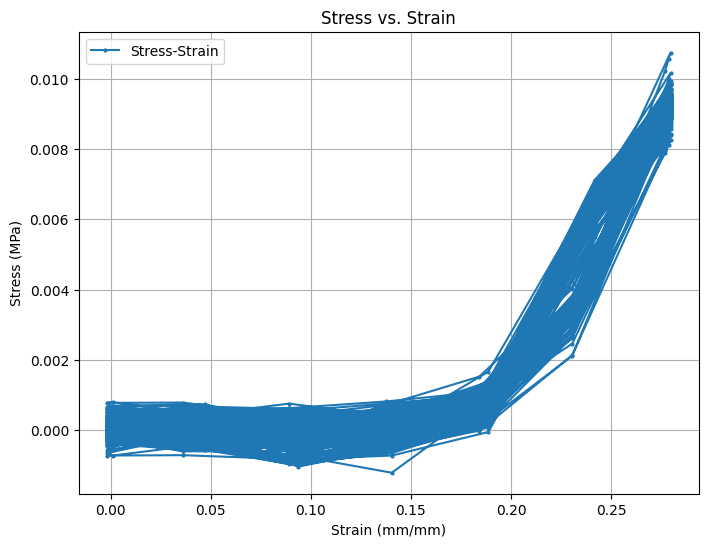

In [1]:
import pandas as pd

raw_tensile_machine_data = pd.read_csv(
    r"/home/ari/Documents/Instron/Specimen_RawData_1.csv",
    skiprows=10,  # skips metadata
    header=0      # first line after skipping becomes header
)
raw_tensile_machine_data.head()
import matplotlib.pyplot as plt

# Convert to numeric in case columns are read as string
raw_tensile_machine_data['Compressive strain'] = pd.to_numeric(raw_tensile_machine_data['Compressive strain'], errors='coerce')
raw_tensile_machine_data['Compressive stress'] = pd.to_numeric(raw_tensile_machine_data['Compressive stress'], errors='coerce')

plt.figure(figsize=(8,6))
plt.plot(
    raw_tensile_machine_data['Compressive strain'], 
    raw_tensile_machine_data['Compressive stress'],
    marker='o', linestyle='-', markersize=2, label='Stress-Strain'
)
plt.xlabel('Strain (mm/mm)')
plt.ylabel('Stress (MPa)')
plt.title('Stress vs. Strain')
plt.grid(True)
plt.legend()
plt.show()


We're performing a **slope change detection algorithm** to identify the contact point where the **load cell first makes contact with a surface**. Before contact, the stress-strain curve remains flat (zero slope) because the load cell experiences no load. After contact, the slope becomes positive as the material begins to resist deformation. The transition point reveals the exact gap distance between the load cell and sensor.

Given discrete data points:
- Strain: $\{\varepsilon_i\}_{i=0}^{n-1}$
- Stress: $\{\sigma_i\}_{i=0}^{n-1}$
- Extension: $\{e_i\}_{i=0}^{n-1}$

Define the discrete derivative (slope) at interval $[i, i+1]$ as:

$$m_i = \begin{cases} \frac{\sigma_{i+1} - \sigma_i}{\varepsilon_{i+1} - \varepsilon_i} & \text{if } \varepsilon_{i+1} \neq \varepsilon_i \\ 0 & \text{otherwise} \end{cases}$$

#### Detection Criterion

For each index $i \in \{2, 3, ..., n-3\}$, compute:

**Pre-transition slopes:**
$$S_{\text{before}}(i) = \{m_{i-2}, m_{i-1}\}$$

**At-transition slope:**
$$m_i = \frac{\sigma_i - \sigma_{i-1}}{\varepsilon_i - \varepsilon_{i-1}}$$

**Post-transition slopes:**
$$S_{\text{after}}(i) = \{m_i, m_{i+1}\}$$

#### Transition Condition

Point $i$ is identified as a transition point if:

$$\begin{aligned}
&\max(S_{\text{before}}(i)) \leq \tau \\
&\min(S_{\text{after}}(i)) > -\tau \\
&m_i > -\tau \\
&\sigma_i \geq 0 \\
&\varepsilon_i \geq 0
\end{aligned}$$

where $\tau$ is the tolerance parameter.

Let $\mathcal{L} = \{i : \text{transition condition holds}\}$ be the set of detected indices.

#### Statistical Estimation

The transition extension is estimated as:

$$\bar{e} = \frac{1}{|\mathcal{L}|} \sum_{i \in \mathcal{L}} e_i$$

with standard error:

$$\text{SE}(\bar{e}) = \frac{1}{\sqrt{|\mathcal{L}|}} \sqrt{\frac{1}{|\mathcal{L}|-1} \sum_{i \in \mathcal{L}} (e_i - \bar{e})^2}$$

#### Physical Interpretation

This algorithm detects regions where:
- The material exhibits a plateau behavior: $|m| \leq \tau$ (pre-transition)
- Followed by continued positive or near-zero deformation: $m > -\tau$ (post-transition)

The tolerance $\tau$ defines the sensitivity threshold for distinguishing between a flat response and active deformation.

In [4]:

import csv
import numpy as np
import matplotlib.pyplot as plt

extension = []
strain = []
stress = []
original_height = 1.33

with open(r'Specimen_RawData_1.csv', 'r') as file:
    csv_reader = csv.reader(file)

    # Skip the first 12 lines
    for _ in range(12):
        next(csv_reader)

    # Read the desired columns from the 13th line onwards
    for row in csv_reader:
        extension.append(float(row[1]))
        strain.append(float(row[3]))
        stress.append(float(row[4]))

# Prepare the data as a table
data = {
    "Extension": extension[:10],
    "Strain": strain[:10],
    "Stress": stress[:10]
}



location = []  # Array to store indices of positive slopes
tolerance = 1e-1  # Tolerance for checking positive slope

for i in range(2, len(strain) - 2):
    slopes_before = []
    for j in range(i-2, i):
        if (strain[j + 1] - strain[j]) != 0:
            slope = (stress[j + 1] - stress[j]) / (strain[j + 1] - strain[j])
        else:
            slope = 0
        slopes_before.append(slope)

    # Check if slope at i is positive
    if (strain[i] - strain[i - 1]) != 0:
        slope_i = (stress[i] - stress[i - 1]) / (strain[i] - strain[i - 1])
    else:
        slope_i = 0

    slopes_after = []
    for j in range(i, i+2):
        if (strain[j + 1] - strain[j]) != 0:
            slope = (stress[j + 1] - stress[j]) / (strain[j + 1] - strain[j])
        else:
            slope = 0
        slopes_after.append(slope)

    if all(slope <= tolerance for slope in slopes_before) \
        and all(slope > -tolerance for slope in slopes_after) \
        and slope_i > -tolerance and stress[i] >= 0 and strain[i] >= 0:
        location.append(i)

extension_at_location = [extension[index] for index in location]
mean_extension = np.mean(extension_at_location)
uncertainty = np.std(extension_at_location) / np.sqrt(len(extension_at_location))

print("Extension:", mean_extension, "mm")
print("(Note: The extension value is negative since the load cell compressing the sensor)")
print("Uncertainty:", uncertainty, "mm")

Extension: -0.4495975478927203 mm
(Note: The extension value is negative since the load cell compressing the sensor)
Uncertainty: 0.01251306841556848 mm


## App Demonstration

An app was created to assist other users- here's a quick demo:

<div style="display: flex; justify-content: center;">
  <img src="Screencast%20from%2011-01-2025%2009_34_15%20PM.gif" alt="App Demo">
</div>